<a href="https://www.kaggle.com/code/shiv1219/walmart-sales-forecast?scriptVersionId=175148558" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Business and Data understanding

We have historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and we have to predict the department-wide sales for each store. Predict the sales for each triplet of store, department, and date.

**Data:**

1. train.csv

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number

Dept - the department number

Date - the week

Weekly_Sales -  sales for the given department in the given store

IsHoliday - whether the week is a special holiday week




2. test.csv

This file is identical to train.csv, except we have withheld the weekly sales. Have to predict the sales for each triplet of store, department, and date in this file.


In [1]:
# All imports go here
import pandas
import numpy
import random
random.seed(4)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# This function was written after modeling, since same code can be used for test data
def load_data(data_to_load='train'):
    # Load Data
    df_raw = pandas.read_csv(f'/kaggle/input/walmart-store-sales/{data_to_load}.csv/{data_to_load}.csv')
    display(df_raw.head())
    df_stores = pandas.read_csv('/kaggle/input/walmart-store-sales/stores.csv')
    display(df_stores.head())
    df_features = pandas.read_csv('/kaggle/input/walmart-store-sales/features.csv/features.csv')
    display(df_features.head())

    # Do needed data merges and get df
    df = df_raw.merge(df_stores, on='Store')
    feature_cols_to_use = ['Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    df = df.merge(df_features[feature_cols_to_use], on=['Store', 'Date'])
    display(df.head())
    return df

df = load_data()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,211.096358,8.106


# EDA

In [3]:
df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,227.232807,14.313000


In [4]:
df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [5]:
# This function was written after modeling. Because same step needs to be done on test data.
def process_loaded_data(df):
    # Fix the data types for columns and create new columns
    df[['Store', 'Dept']] = df[['Store', 'Dept']].astype(str)
    df['Date'] = pandas.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year.astype(str)
    df['Month'] = df['Date'].dt.month.astype(str)
    return df

df = process_loaded_data(df)

In [6]:
# No missing data
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Year            0
Month           0
dtype: int64

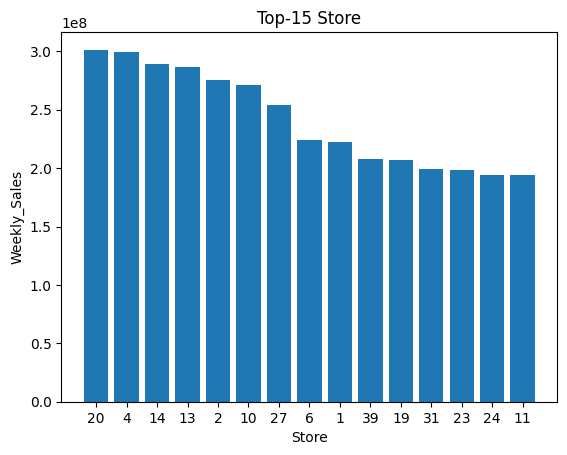

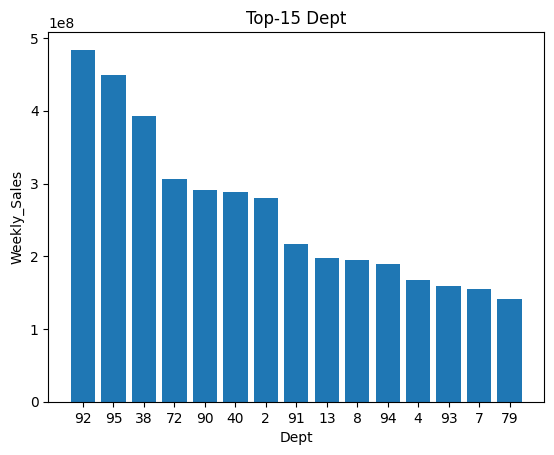

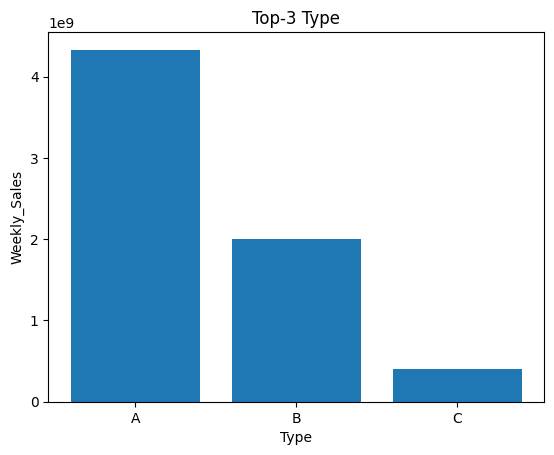

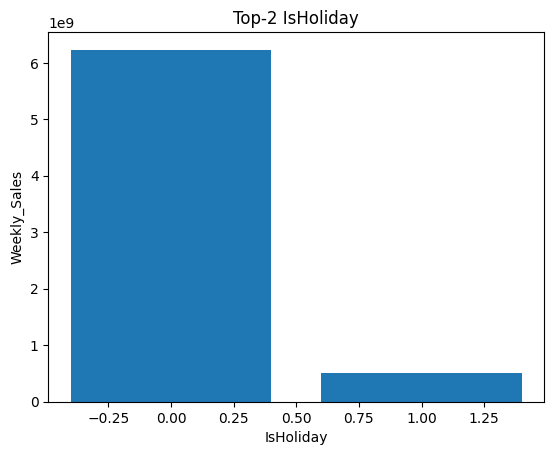

In [7]:
def plot_bar(x_col, y_col='Weekly_Sales', top_n=15):

    # Create a frequency table for the "Product" column
    table = df.groupby(x_col)[y_col].sum().sort_values(ascending=False)

    # Print the frequency table
    # print(frequency_table)

    # Create a bar chart
    plt.bar(table.index[:top_n], table.values[:top_n])

    # Set the chart title and axes labels
    plt.title(f'Top-{min(top_n, len(table.index))} {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    # Display the chart
    plt.show()
    
plot_bar('Store')
plot_bar('Dept')
plot_bar('Type')
plot_bar('IsHoliday')

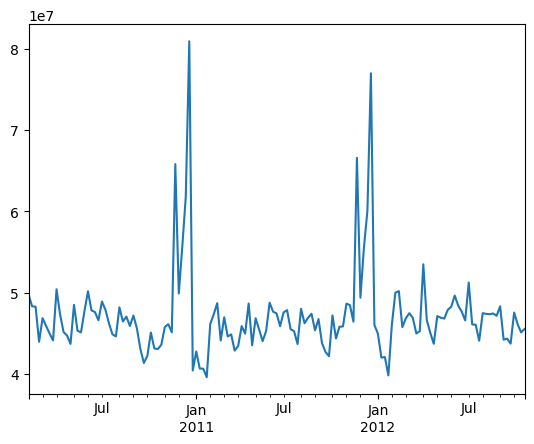

In [8]:
# Weekly Sales
data = df.groupby("Date")["Weekly_Sales"].sum()
data.plot()
plt.xlabel(None)
plt.show()

Here we can see that we have 45 stores and 81 departments

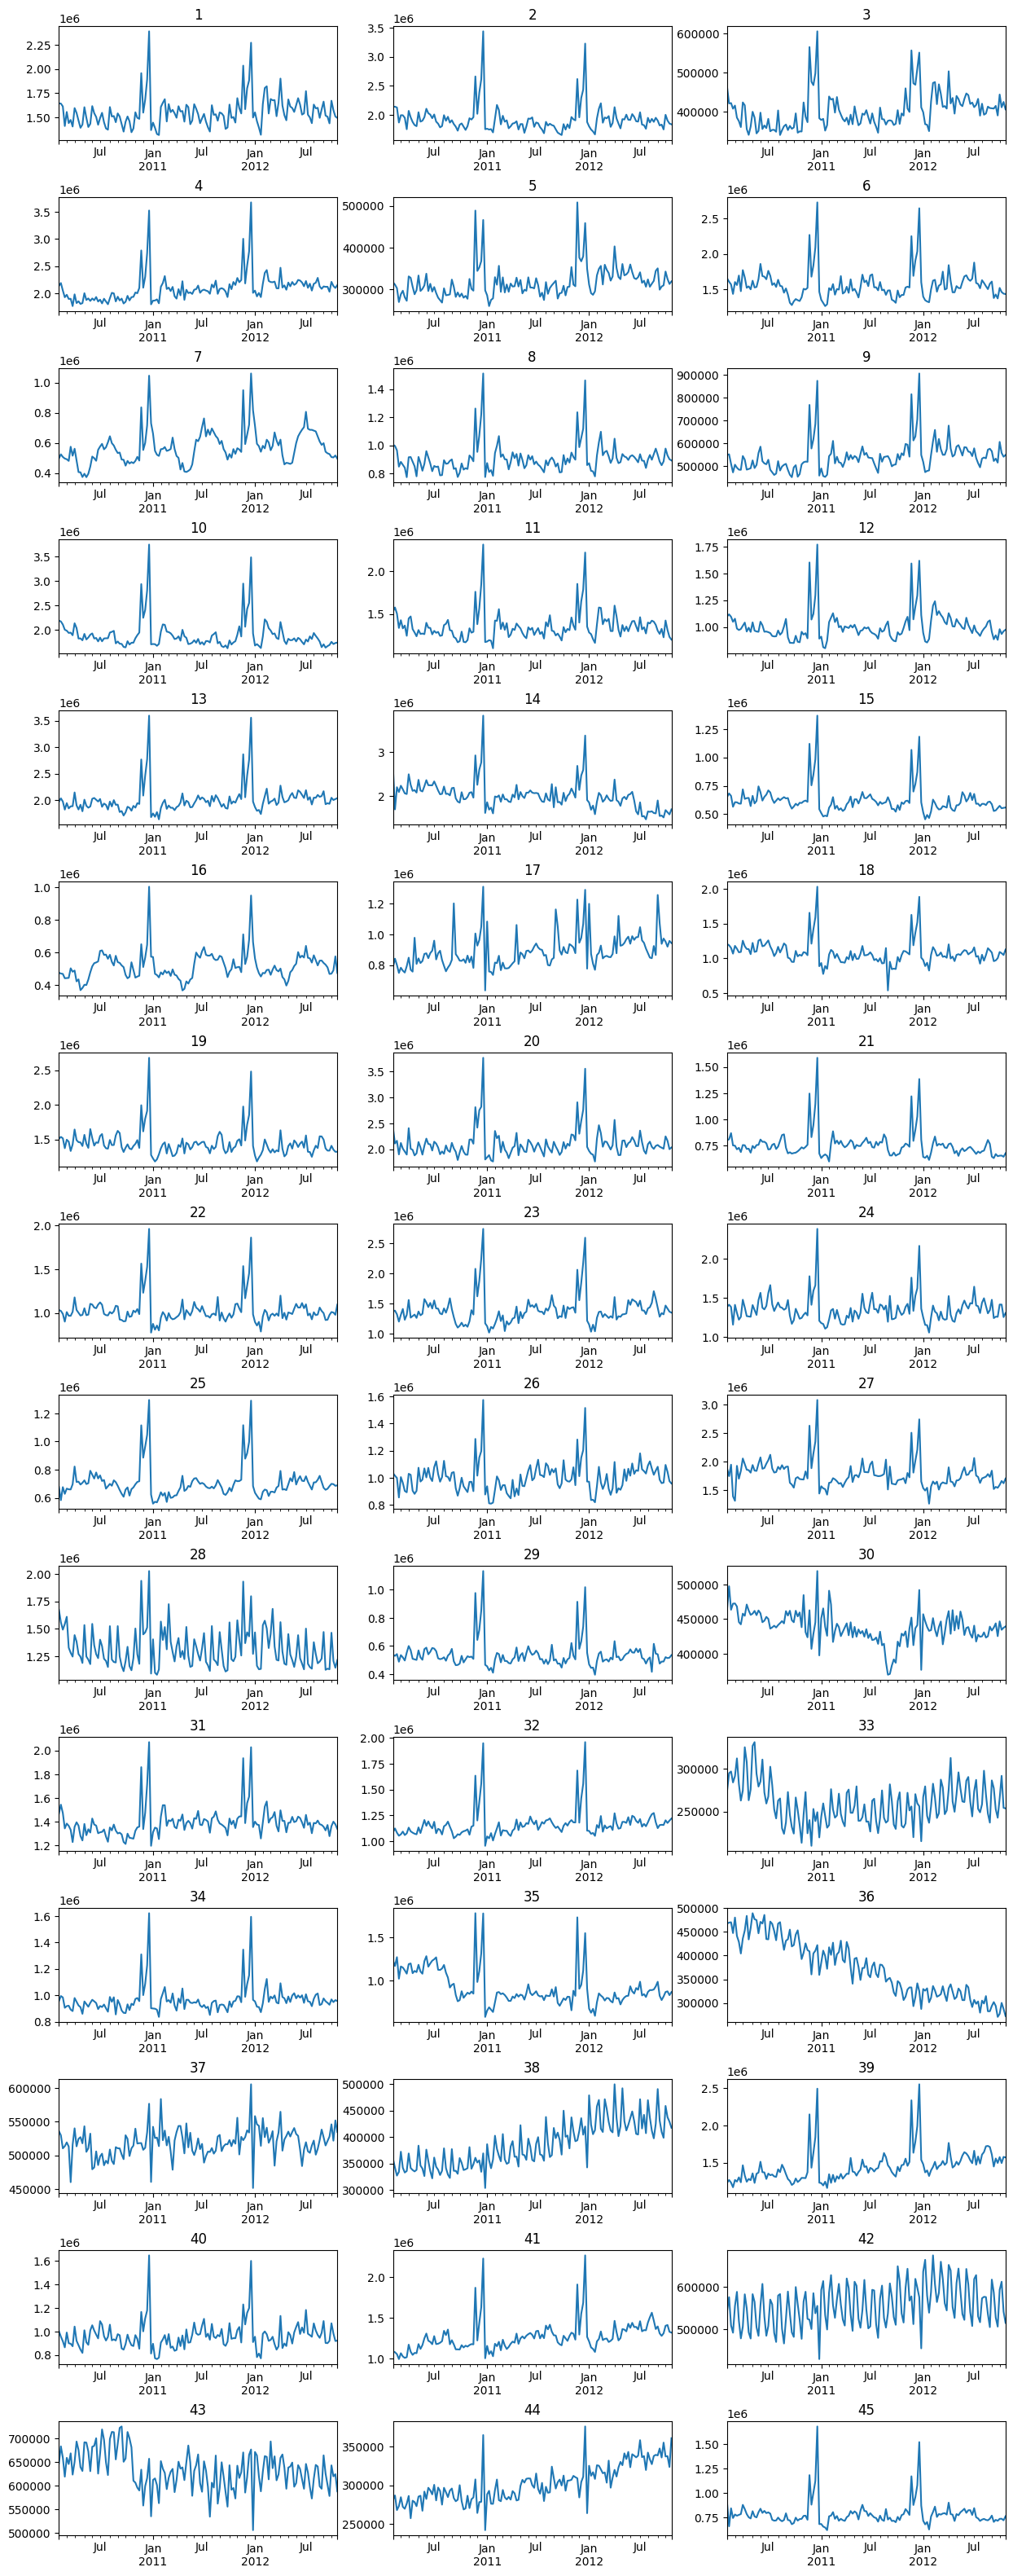

In [9]:
# Store wise weekly Sales
plt.figure(figsize=(15, 40))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

for store, df_store in df.groupby('Store'):
    data = df_store.groupby("Date")["Weekly_Sales"].sum()
    plt.subplot(15, 3, int(store))
    data.plot()
    plt.title(store)
    plt.xlabel(None)

plt.show()


Test data

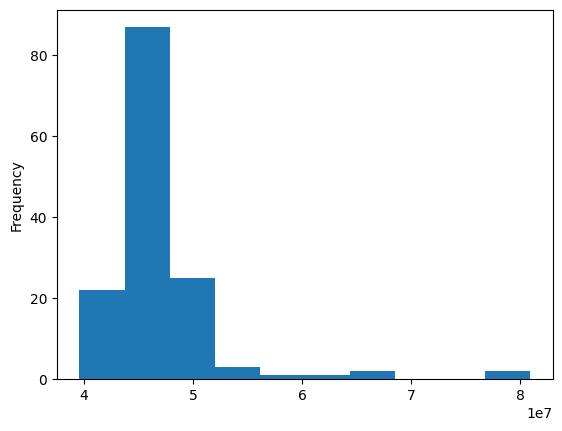

In [10]:
# Weekly Sales Distribution
data = df.groupby(["Date", 'IsHoliday'])["Weekly_Sales"].sum()
data.plot.hist()
plt.show()

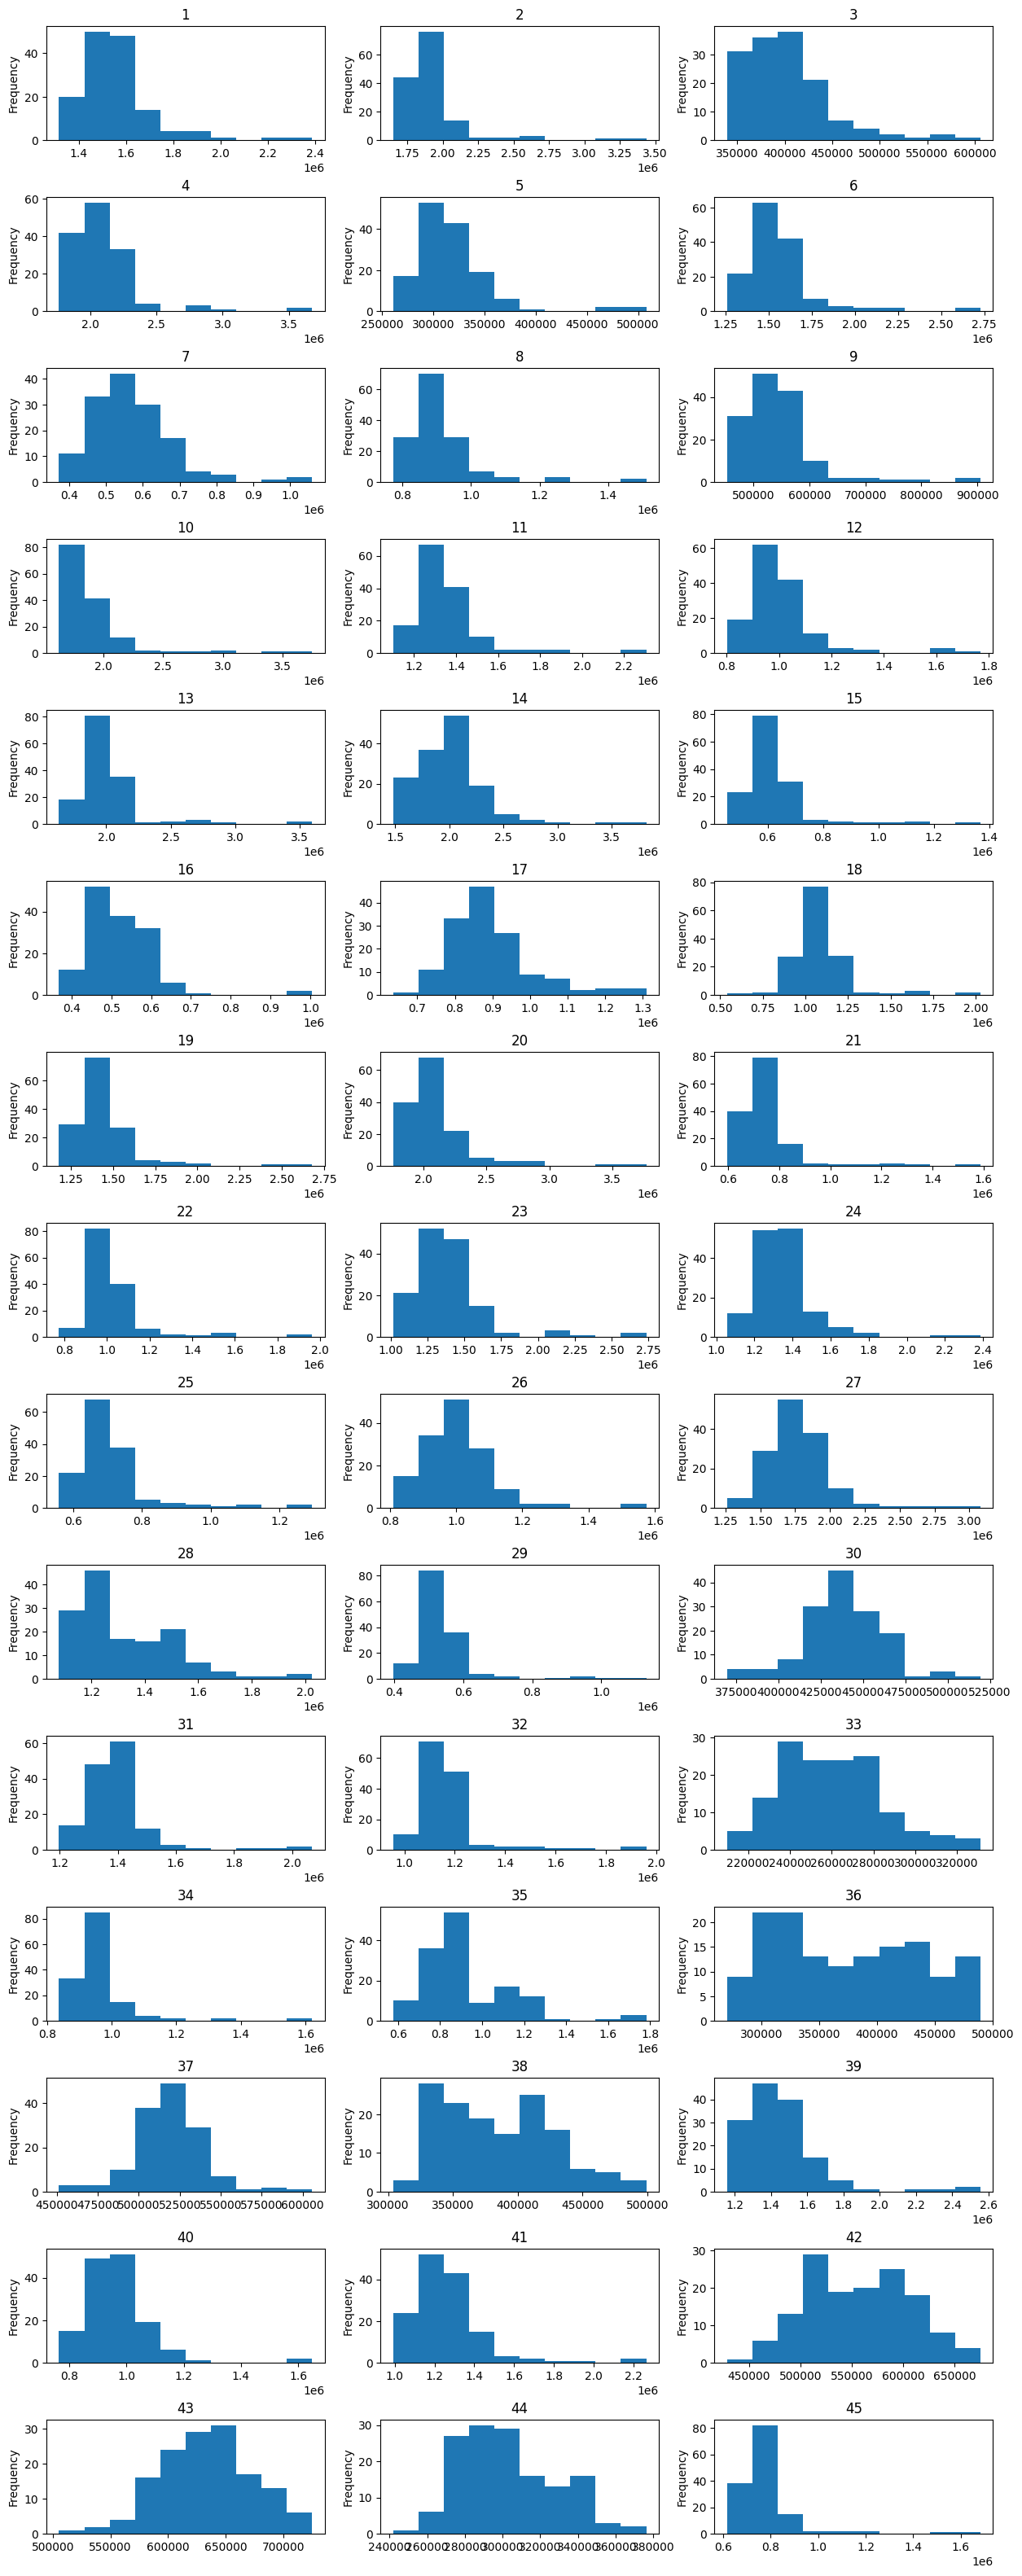

In [11]:
# Store Wise weekly Sales Distribution
plt.figure(figsize=(15, 40))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

for store, df_store in df.groupby('Store'):
    data = df_store.groupby(["Date", 'IsHoliday'])["Weekly_Sales"].sum()
    plt.subplot(15, 3, int(store))
    plt.title(store)
    data.plot.hist()
    
plt.show()

There are store which have outliers in weekly sales. That maybe because of holiday's or any other reason.

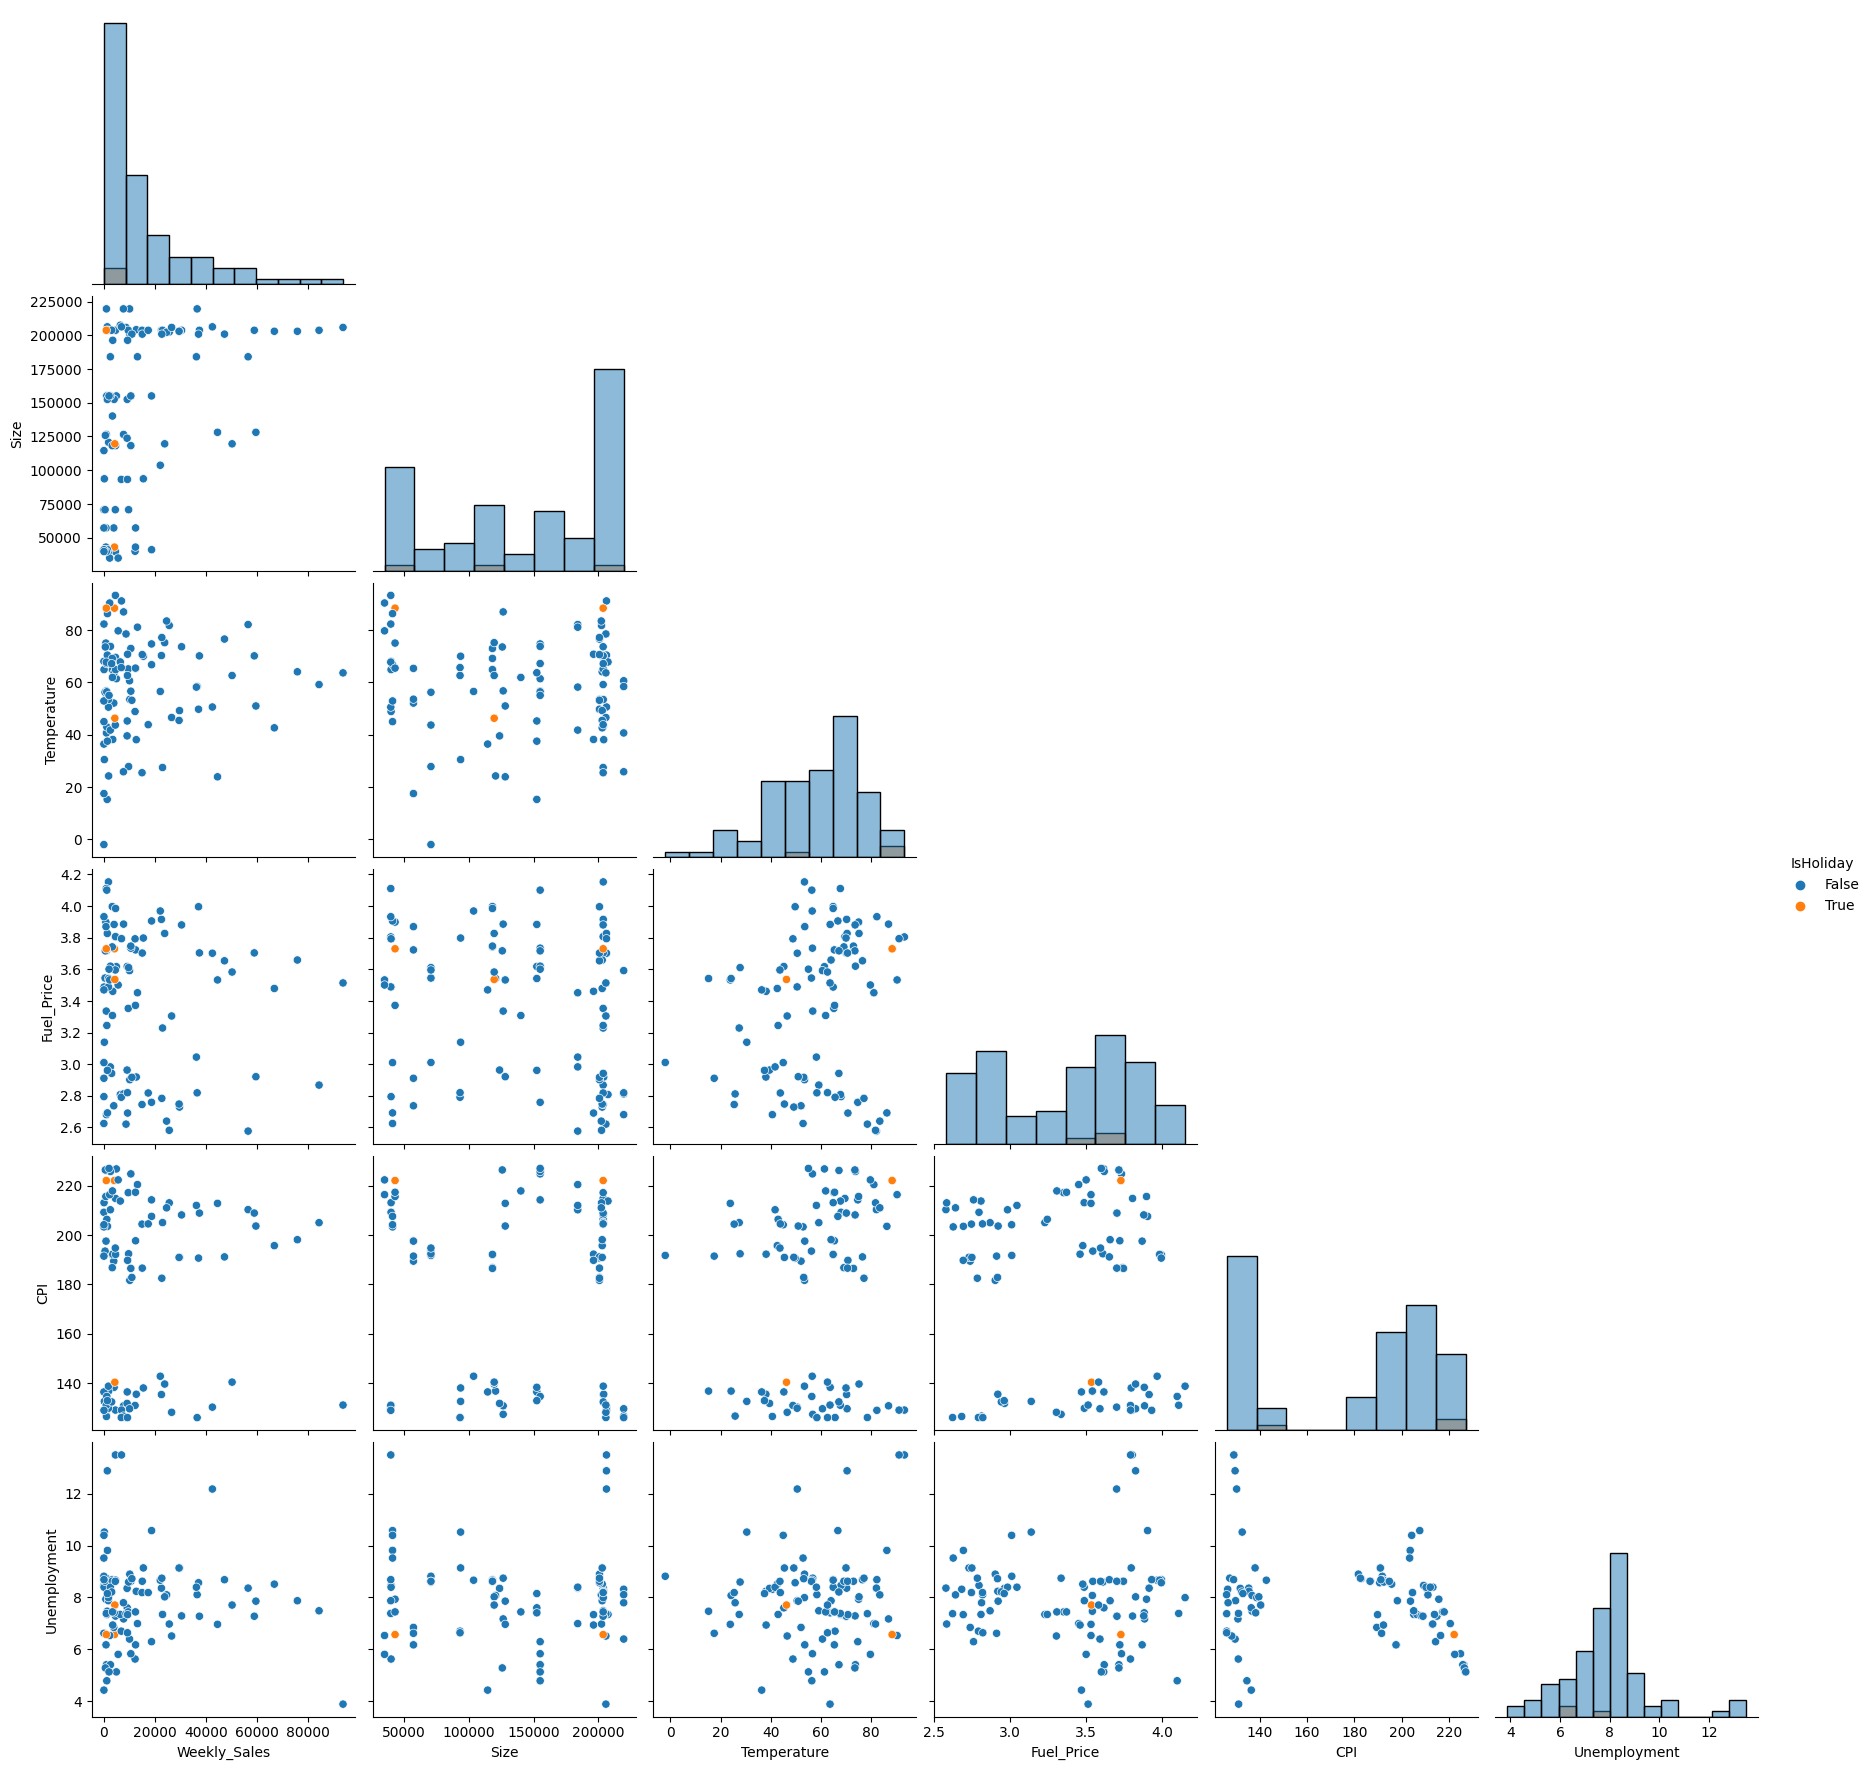

In [12]:
# Make sure you take sample data or it will take lot of time to plot this.
sns.pairplot(df.sample(100, random_state=4), hue="IsHoliday", size=3, diag_kind="hist", corner=True)
plt.show()

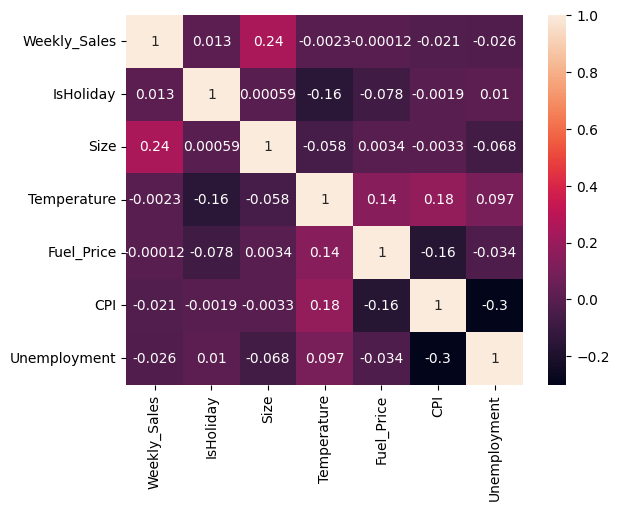

In [13]:
sns.heatmap(df.corr(numeric_only=True), annot = True)
plt.show()

In [14]:
df.dtypes

Store                   object
Dept                    object
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Year                    object
Month                   object
dtype: object

# Modeling

In [15]:
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=numpy.nan, strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputation_most_frequent",
            SimpleImputer(fill_value="missing", strategy="most_frequent"),
        ),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop='first')),
    ]
)

categorical_col = ['Store', 'Dept', 'Type', 'IsHoliday', 'Month']
numerical_col = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, categorical_col),
        ("numerical", numeric_preprocessor, numerical_col),
    ]
)

preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputation_most_frequent',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Store', 'Dept', 'Type', 'IsHoliday',
                                  'Month']),
                                ('numerical',
                                 Pipeline(steps=[('imputation_mean',
                                                  SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Size', 'Temperature', 'Fuel_Price', 'CPI',
                                  'Unemployment'])])

In [16]:
df_sample = df.sample(5000, random_state=4)
X = df_sample[categorical_col+numerical_col]
y= df_sample[['Date','Weekly_Sales']].set_index('Date')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 10)

In [17]:
X_train.head(), y_train.head()

(       Store Dept Type  IsHoliday Month    Size  Temperature  Fuel_Price  \
 37665      4   37    A      False     4  205863        67.69       3.864   
 160395    17   98    B       True    11   93188        19.03       2.830   
 345559    36   18    A      False     6   39910        80.74       3.567   
 102446    11    7    A      False     5  207499        80.93       3.899   
 237152    25   81    B      False     2  128107        21.10       2.784   
 
                CPI  Unemployment  
 37665   131.037548         4.308  
 160395  126.669267         6.885  
 345559  220.432210         6.989  
 102446  219.368356         7.574  
 237152  204.247194         8.187  ,
             Weekly_Sales
 Date                    
 2012-04-06       3979.94
 2010-11-26        995.19
 2012-06-01          3.80
 2011-05-13      27584.74
 2010-02-05       9073.67)

In [18]:
rf = RandomForestRegressor(random_state=4)
ls = Lasso(random_state=4, selection='random', tol=1e-3)
rd = Ridge(random_state=4, tol=1e-3)
models_to_try = [rf, ls, rd]

In [19]:
all_pipelines = {}
for m in models_to_try:
    # Create a scikit-learn pipeline
    all_pipelines[m] = pipeline = make_pipeline(preprocessor, m)
    # Perform cross-validation on the training data
    cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=4, scoring='r2')
    print(m)
    print(f"Cross-Validation Scores: {cross_val_scores}")
    print(f"Mean Cross-Validation Score: {numpy.mean(cross_val_scores)}\n")

RandomForestRegressor(random_state=4)
Cross-Validation Scores: [0.7827704  0.84341914 0.83550007 0.84843548]
Mean Cross-Validation Score: 0.827531273795064

Lasso(random_state=4, selection='random', tol=0.001)
Cross-Validation Scores: [0.62956325 0.6984907  0.6680257  0.65838777]
Mean Cross-Validation Score: 0.6636168527080069

Ridge(random_state=4, tol=0.001)
Cross-Validation Scores: [0.62892964 0.69697807 0.66650248 0.66125135]
Mean Cross-Validation Score: 0.6634153868751338



In [20]:
# As seen above the best model is RandomForestRegressor
# Fit the RF model on training data
all_pipelines[rf].fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputation_most_frequent',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Store', 'Dept', 'Type',
                                                   'IsHoliday', 'Month']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputation_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Size', 'Temperature',
                                                   'Fuel_Price', 'CPI',
                                                   'Unemployment'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=4))])

In [21]:
# Use only selected model to predict on the test data
y_pred = all_pipelines[rf].predict(X_test)
rmse = numpy.sqrt(mean_squared_error(y_pred, y_test))
r2 = r2_score(y_pred, y_test)
print(f'Test RMSE of best model = {rmse}')
print(f'Test R2 Score of best model = {r2}')

Test RMSE of best model = 7967.877153699796
Test R2 Score of best model = 0.8237237417546782


In [22]:
# Refit the model on full training data (took small sample)
df_temp = df.sample(50000, random_state=4, replace=True)
X = df_temp[categorical_col+numerical_col]
y = df_temp[['Date','Weekly_Sales']].set_index('Date')

all_pipelines[rf].fit(X, y)
y_pred = all_pipelines[rf].predict(X)
rmse = numpy.sqrt(mean_squared_error(y_pred, y))
r2 = r2_score(y_pred, y)
# Note this is supposed to be high, since this is training RMSE and R2
print(f'Final Training RMSE = {rmse}')
print(f'Final Training R2 Score = {r2}')

Final Training RMSE = 2266.741888910254
Final Training R2 Score = 0.9899506731357204


Optional (Let us submit the test to competition)

In [23]:
df_test = load_data('test')
df_test = process_loaded_data(df_test)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,223.462779,6.573
4,1,5,2012-11-02,False,A,151315,55.32,3.386,223.462779,6.573


In [24]:
submission = pandas.read_csv("/kaggle/input/walmart-store-sales/sampleSubmission.csv/sampleSubmission.csv")
submission['Weekly_Sales'] = all_pipelines[rf].predict(df_test)
submission.to_csv('submission.csv', index=False)